We need to write a primer for sources of background emission for JWST. 
In preparation, making some illustrative plots.

Draft 27 Sept 2016 by Jane Rigby

In [1]:
%pylab
%matplotlib inline
import pandas
from astropy.table import Table
from   scipy.interpolate import interp1d
import jrr
pylab.rcParams['figure.figsize'] = (11, 9)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('axes', linewidth=2)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# This is Jane's cobbled-together backgrounds, from running sirtf BackgroundModel.c
miri_dir = "/Volumes/Apps_and_Docs/MISSIONS/JWST/MIRI_bkgs/"
zodi_dir = "/Volumes/Apps_and_Docs/MISSIONS/JWST/ETC/1.2minzody/"
therm = pandas.read_csv(miri_dir + "thermal_curve_jwst_jrigby_1.1.csv",  comment="#", names=("wave","SB"))
jrr_sirtf = pandas.read_table(zodi_dir + "bkgs_one_file.txt", delim_whitespace=True, comment="#")
jrr_sirtf.head()

,wave,total,zodiacal,ISM,CIB
0,0.5,0.131274,0.130800,0.000474,0.0
1,0.6,0.168378,0.167647,0.000732,0.0
2,0.7,0.172238,0.171181,0.001057,0.0
3,0.8,0.162196,0.160743,0.001453,0.0
4,0.9,0.152530,0.150606,0.001924,0.0


In [3]:
# This is example file that STScI sent me.  Should be 1.2 min zody
stsci_file = "stsci_background.fits"
stsci_df = Table.read(zodi_dir + stsci_file).to_pandas()
stsci_df.head()

,wavelength,background,thermal,straylight,infield
0,0.5,0.178681,0.0,0.029370,0.149311
1,1.0,0.305930,0.0,0.089069,0.216862
2,1.5,0.247307,0.0,0.087651,0.159656
3,2.0,0.203855,0.0,0.080966,0.122889
4,2.5,0.174696,0.0,0.080478,0.094217


In [4]:
# compare to bkg file I made using ETC
myfile = "bkg_1.2minzody_fromETCrun112016.fits"
tab = Table.read(myfile)  # to astropy tables format
mydf = tab.to_pandas()    # to pandas format
mydf.head()

,wavelength,background,thermal,straylight,infield
0,0.5,0.175350,0.0,0.026039,0.149311
1,0.6,0.247288,0.0,0.049512,0.197777
2,0.7,0.277663,0.0,0.055278,0.222384
3,0.8,0.288427,0.0,0.057968,0.230459
4,0.9,0.291130,0.0,0.064263,0.226866


In [5]:
wave_lo = 0.5  # micron
wave_hi = 30.0 # micron
incr    = 0.1  # micron
wave = np.arange(wave_lo, wave_hi, incr)
total = jrr.spec.rebin_spec_new(jrr_sirtf.wave, jrr_sirtf.zodiacal, wave, fill=0) + \
    jrr.spec.rebin_spec_new(jrr_sirtf.wave, jrr_sirtf.ISM, wave, fill=0) + \
    jrr.spec.rebin_spec_new(stsci_df.wavelength, stsci_df.straylight, wave, fill=0) + \
    jrr.spec.rebin_spec_new(therm.wave, therm.SB, wave, fill=0)

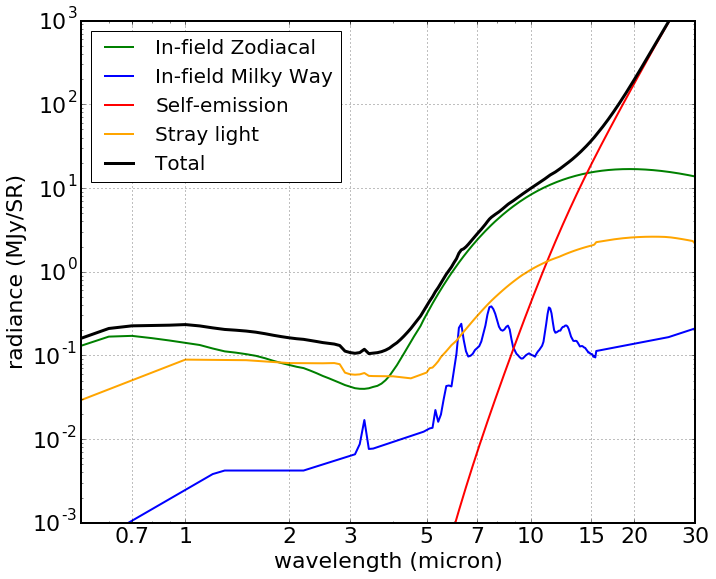

In [6]:
plt.plot(jrr_sirtf.wave, jrr_sirtf.zodiacal, color='green', label="In-field Zodiacal", linewidth=2)
plt.plot(jrr_sirtf.wave, jrr_sirtf.ISM,  color='blue', label="In-field Milky Way", linewidth=2)
plt.plot(therm.wave, therm.SB, color='red', label="Self-emission", linewidth=2)
plt.plot(stsci_df.wavelength, stsci_df.straylight, color='orange', label="Stray light", linewidth=2)
plt.plot(wave, total, label="Total", linewidth=3, color='black')
plt.legend(loc=2, fontsize=20)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,30)
plt.ylim(1E-3,1E3)
plt.xlabel("wavelength (micron)")
plt.ylabel("radiance (MJy/SR)")
label_x = (0.7,1,2,3,5,7,10,15,20,30)
plt.xticks(label_x, label_x)
plt.savefig('jwst_primer_backgrounds.pdf')

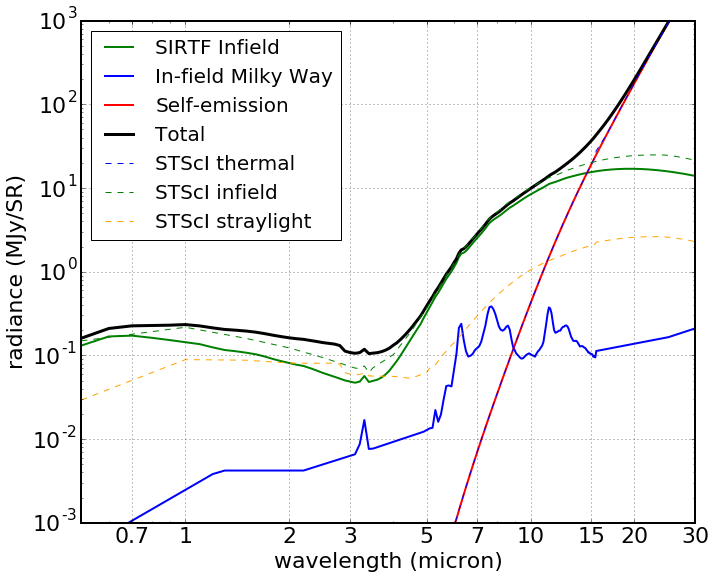

In [7]:
# Compare the STScI curve w my hacked-together curve
plt.plot(jrr_sirtf.wave, jrr_sirtf.zodiacal + jrr_sirtf.ISM, color='green', label="SIRTF Infield", linewidth=2)
plt.plot(jrr_sirtf.wave, jrr_sirtf.ISM,  color='blue', label="In-field Milky Way", linewidth=2)
plt.plot(therm.wave, therm.SB, color='red', label="Self-emission", linewidth=2)
plt.plot(wave, total, label="Total", linewidth=3, color='black')

plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,30)
plt.ylim(1E-3,1E3)
plt.xlabel("wavelength (micron)")
plt.ylabel("radiance (MJy/SR)")
label_x = (0.7,1,2,3,5,7,10,15,20,30)
plt.xticks(label_x, label_x)
stsci_df = Table.read(zodi_dir + "stsci_background.fits").to_pandas()
plt.plot(stsci_df.wavelength, stsci_df.thermal, label="STScI thermal", linestyle='dashed')
plt.plot(stsci_df.wavelength, stsci_df.infield, label="STScI infield", linestyle='dashed')
plt.plot(stsci_df.wavelength, stsci_df.straylight, label="STScI straylight", linestyle='dashed', color='orange')
plt.legend(loc=2, fontsize=20)

In [8]:
#Good.  The file from stsci (stsci_background.fits) is generally what I'd expect, 
# although the in-field normalization is higher.  Bad day?


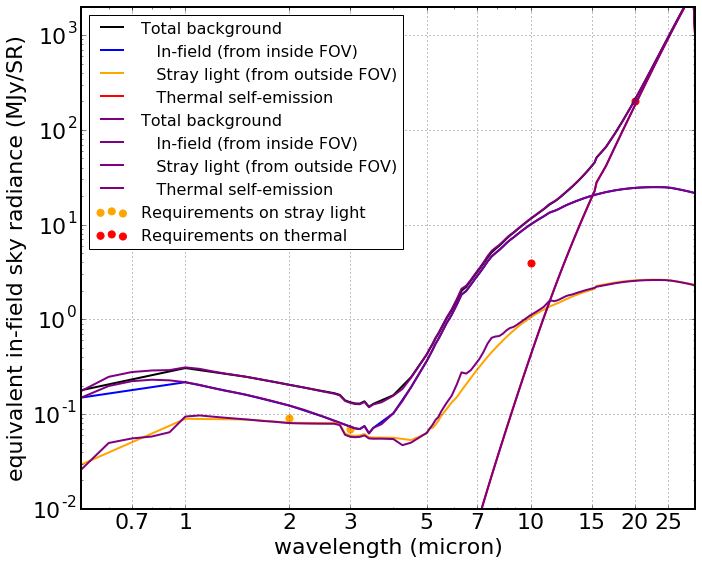

In [9]:
# Let's check that the new bkg file is reasonable, compare to stsci's old bkg file
#Let's make a new plot for publication, using STScI's file.
plt.plot(stsci_df.wavelength, stsci_df.background, label="Total background", linewidth=2, color='k')
plt.plot(stsci_df.wavelength, stsci_df.infield, label="   In-field (from inside FOV)", linewidth=2)
plt.plot(stsci_df.wavelength, stsci_df.straylight, label="   Stray light (from outside FOV)", linewidth=2, color='orange')
plt.plot(stsci_df.wavelength, stsci_df.thermal, label="   Thermal self-emission", linewidth=2, color='red')
plt.plot(mydf.wavelength, mydf.background, label="Total background", linewidth=2, color='purple')
plt.plot(mydf.wavelength, mydf.infield, label="   In-field (from inside FOV)", linewidth=2, color='purple')
plt.plot(mydf.wavelength, mydf.straylight, label="   Stray light (from outside FOV)", linewidth=2, color='purple')
plt.plot(mydf.wavelength, mydf.thermal, label="   Thermal self-emission", linewidth=2, color='purple')
plt.scatter((2., 3.), (0.09, 0.07), s=50, label="Requirements on stray light", color="orange")
plt.scatter((10., 20.), (3.9, 200), s=50, label="Requirements on thermal", color="red")

plt.legend(loc=2, fontsize=16)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,29.9)
plt.ylim(1E-2,2E3)
plt.xlabel("wavelength (micron)")
plt.ylabel("equivalent in-field sky radiance (MJy/SR)")
label_x = (0.7,1,2,3,5,7,10,15,20,25)
plt.xticks(label_x, label_x)
plt.savefig('jwst_primer_backgrounds_compare_new_old_bkgfile.pdf')

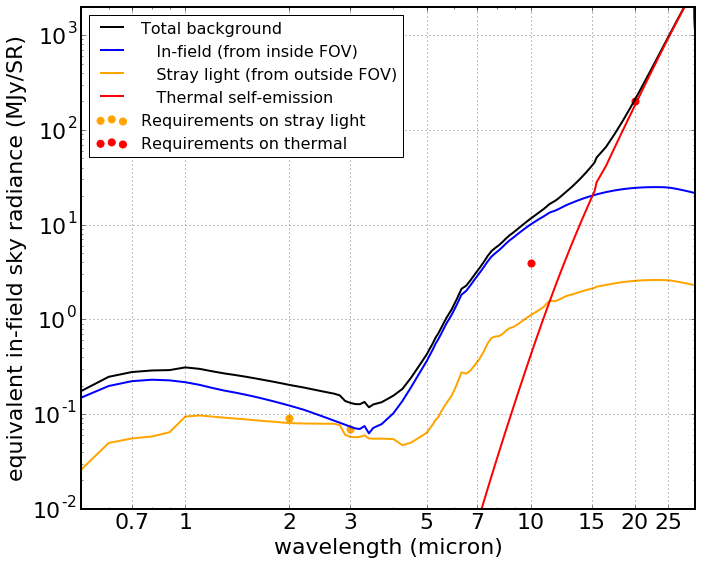

In [10]:
#Let's make a new plot for publication, using my new (nov 2016) bkg file
plt.plot(mydf.wavelength, mydf.background, label="Total background", linewidth=2, color='k')
plt.plot(mydf.wavelength,mydf.infield, label="   In-field (from inside FOV)", linewidth=2)
plt.plot(mydf.wavelength, mydf.straylight, label="   Stray light (from outside FOV)", linewidth=2, color='orange')
plt.plot(mydf.wavelength, mydf.thermal, label="   Thermal self-emission", linewidth=2, color='red')
plt.scatter((2., 3.), (0.09, 0.07), s=50, label="Requirements on stray light", color="orange")
plt.scatter((10., 20.), (3.9, 200), s=50, label="Requirements on thermal", color="red")

plt.legend(loc=2, fontsize=16)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,29.9)
plt.ylim(1E-2,2E3)
plt.xlabel("wavelength (micron)")
plt.ylabel("equivalent in-field sky radiance (MJy/SR)")
label_x = (0.7,1,2,3,5,7,10,15,20,25)
plt.xticks(label_x, label_x)
plt.savefig('jwst_primer_backgrounds_new.png')